# Multi-label classifier for PASCAL_2012 image data

Started on Apr 29, 2021. The purpose of this nb is to continue to retrain my python and fastai skills. I'll be following along with fastbook ch6, but I'll use the 2012 data instead of the 2007 data.

http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

- 11,530 images containing 27,450 ROI (region of interest) annotated objects
- 20 classes
  - Person: person
  - Animal: bird, cat, cow, dog, horse, sheep
  - Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
  - Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor
- 50/50 train/val split

Note that the fastai download for PASCAL 2012 might be different than what's written above, so just go with that!

In [ ]:
from fastai.vision.all import *

# explore

In [ ]:
path = untar_data(URLs.PASCAL_2012)
Path.BASE_PATH = path
path.ls()

(#6) [Path('valid.json'),Path('train.csv'),Path('segmentation'),Path('train'),Path('test'),Path('train.json')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [ ]:
df.shape

(11540, 3)

To make the DataBlock from the df, make helper functions that take the df as their param.

In [ ]:
df.index[~df['is_valid']].tolist()

In [ ]:
df.index[df['is_valid']]

Int64Index([    0,     1,     2,     4,     6,     8,    10,    11,    13,
               15,
            ...
            11523, 11524, 11528, 11530, 11532, 11533, 11534, 11535, 11536,
            11538],
           dtype='int64', length=5823)

# dls

In [ ]:
def get_x(df): return path/'train'/df['fname']
def get_y(df): return df['labels'].split(' ')
def splitter(df):
    """Use df.index to return two lists of indeces."""
    t_idxs = df.index[~df['is_valid']].tolist()
    v_idxs = df.index[df['is_valid']].tolist()
    return t_idxs, v_idxs

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

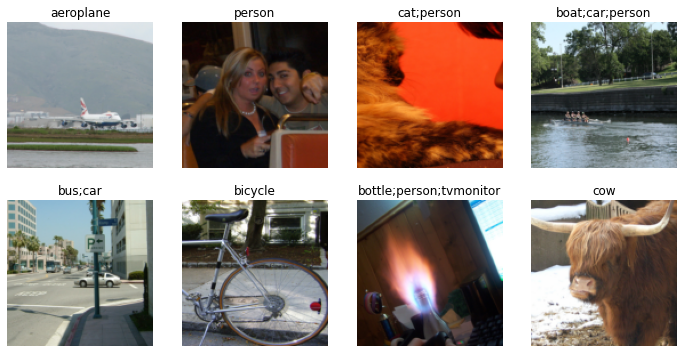

In [ ]:
dls.show_batch(nrows=2, ncols=4)

# learn

The loss function we'll use is the confusingly named BCEWithLogitsLoss. It's just this:

`def loss_f(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()`

In [ ]:
loss_f = nn.BCEWithLogitsLoss()

The metric we'll use is accuracy with a threshold of 0.3. This threshold is chosen arbitrarily at this time, and after we train the model, we'll look for better thresholds.

In [ ]:
met = partial(accuracy_multi, thresh=0.3)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=met)

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.857262,0.618176,0.381401,00:12
1,0.576250,0.231850,0.875348,00:12
2,0.230957,0.112555,0.955968,00:12
3,0.144761,0.104287,0.960081,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.114984,0.105971,0.959754,00:14
1,0.102567,0.097851,0.962382,00:14
2,0.080741,0.091847,0.964185,00:15


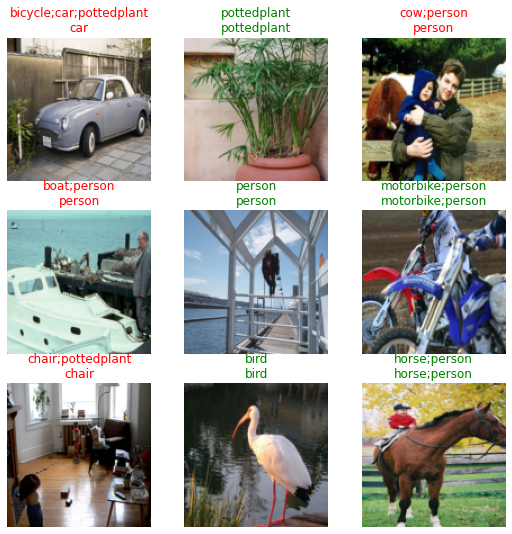

In [ ]:
learn.show_results()

# Finding the best accuracy threshold

Let's look at difference thresholds to find the one that yields the most accurate predictions.

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.0918465256690979,0.9359265565872192]

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.0918465256690979,0.9456464052200317]

Let's be smarter about this. Let's start out our smartness by grabbing the preds once:

In [ ]:
yp,y = learn.get_preds()

... then calling accuracy_multi() using yp and y:

In [ ]:
accuracy_multi(yp, y, thresh=0.9, sigmoid=False)

TensorBase(0.9601)

... then finally creating an array of accuracies by looping over different thresholds and visualizing the results to find the thresh that yields the best acc:

In [ ]:
ths = torch.linspace(0.05, .95, 29)
ths

tensor([0.0500, 0.0821, 0.1143, 0.1464, 0.1786, 0.2107, 0.2429, 0.2750, 0.3071,
        0.3393, 0.3714, 0.4036, 0.4357, 0.4679, 0.5000, 0.5321, 0.5643, 0.5964,
        0.6286, 0.6607, 0.6929, 0.7250, 0.7571, 0.7893, 0.8214, 0.8536, 0.8857,
        0.9179, 0.9500])

In [ ]:
accs = [accuracy_multi(yp, y, thresh=th, sigmoid=False) for th in ths]
accs

[TensorBase(0.9032),
 TensorBase(0.9280),
 TensorBase(0.9410),
 TensorBase(0.9489),
 TensorBase(0.9541),
 TensorBase(0.9583),
 TensorBase(0.9610),
 TensorBase(0.9630),
 TensorBase(0.9645),
 TensorBase(0.9657),
 TensorBase(0.9665),
 TensorBase(0.9670),
 TensorBase(0.9676),
 TensorBase(0.9679),
 TensorBase(0.9680),
 TensorBase(0.9680),
 TensorBase(0.9679),
 TensorBase(0.9675),
 TensorBase(0.9673),
 TensorBase(0.9670),
 TensorBase(0.9664),
 TensorBase(0.9658),
 TensorBase(0.9653),
 TensorBase(0.9644),
 TensorBase(0.9636),
 TensorBase(0.9623),
 TensorBase(0.9609),
 TensorBase(0.9591),
 TensorBase(0.9560)]

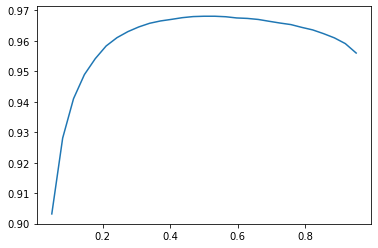

In [ ]:
plt.plot(ths, accs);

Interesting! Accuracy improves quickly as we move from ~0 to .3, then it peaks at around .5, then declines slowly until around .8, which is where it starts to quickly fall down again.

That being said, every single thresh charted strikes me as being "accurate enough" – the acc for .05 is over 90%, and the acc for .95 is over 95%!